In [1]:
!pip install tensorflow
!pip install opencv-python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2022-04-02 08:35:22.937051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-02 08:35:22.937113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])
    
    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

In [4]:
faces=('/home/jovyan/Bloc_6/olivetti_faces.npy')
faces_target=('/home/jovyan/Bloc_6/olivetti_faces_target.npy')

In [5]:
face_images = np.load(faces)
face_labels = np.load(faces_target)

In [6]:
def show_40_distinct_people(images1, unique_ids):
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axarr=axarr.flatten()
    
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images1[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

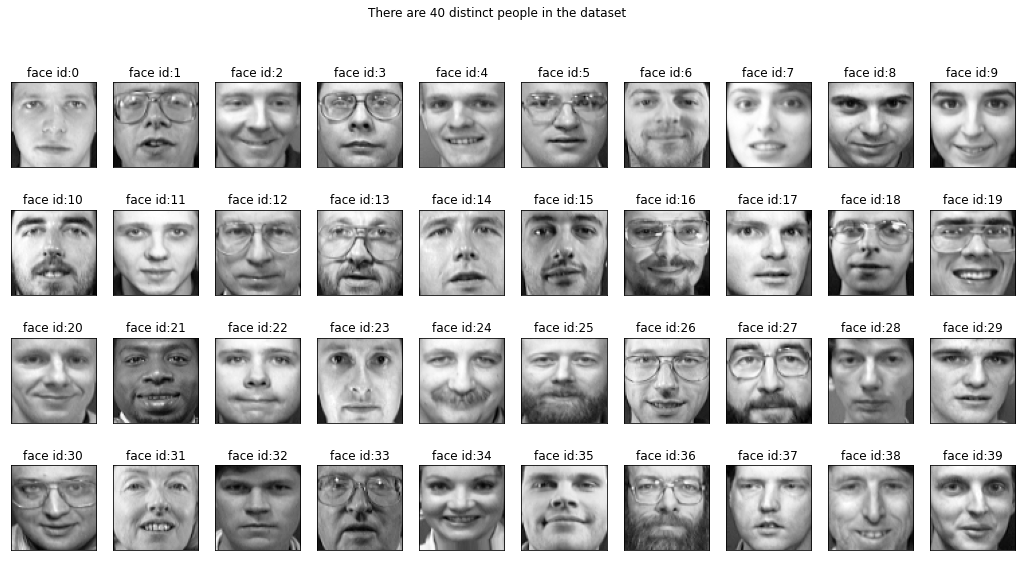

In [7]:
show_40_distinct_people(face_images, np.unique(face_labels))

In [8]:
def show_10_faces_of_n_subject(images1, subject_ids):
    cols=10
    rows=(len(subject_ids)*10)/cols #
    rows=int(rows)
    
    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,4))
    
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(images1[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))

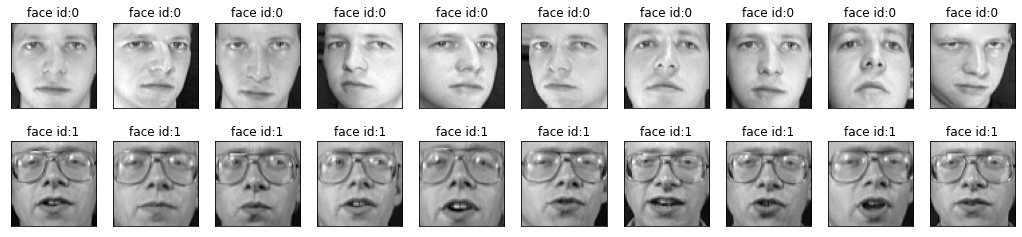

In [9]:
show_10_faces_of_n_subject(images1=face_images, subject_ids=[0,1])

In [10]:
target_shape = face_images[0].shape

In [11]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [12]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

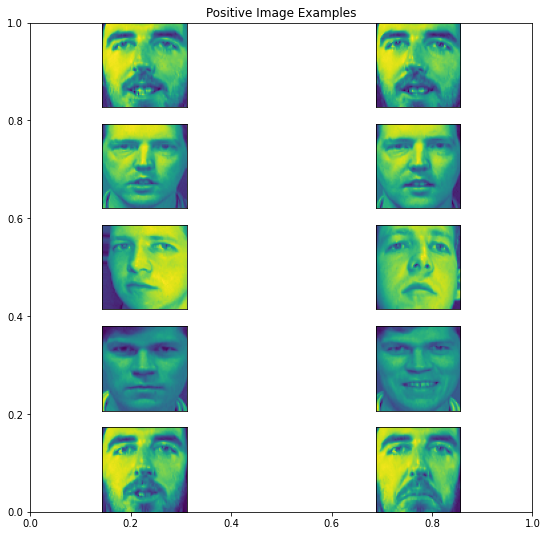

In [13]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

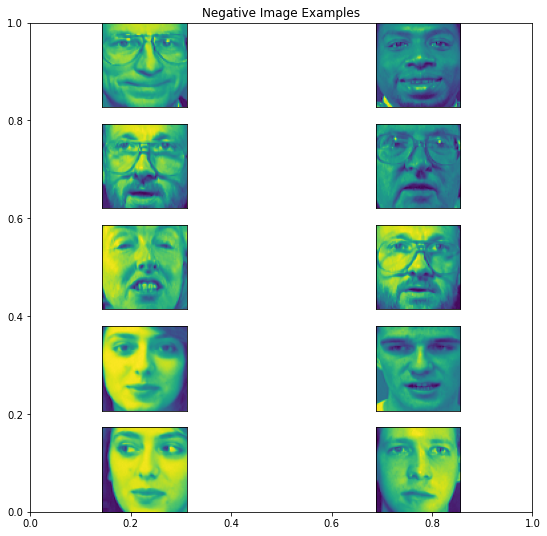

In [14]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

In [15]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

2022-04-02 08:35:29.510109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-02 08:35:29.510182: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-02 08:35:29.510257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-pisonlud-40gmail-2ecom): /proc/driver/nvidia/version does not exist
2022-04-02 08:35:29.510583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
import tensorflow.keras.backend as K

In [17]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [18]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [19]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

In [20]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 81s 8s/step - loss: 0.6705 - accuracy: 0.5047 - val_loss: 0.6375 - val_accuracy: 0.5312
Epoch 2/150
10/10 [==============================] - 79s 8s/step - loss: 0.6328 - accuracy: 0.5047 - val_loss: 0.6885 - val_accuracy: 0.7312
Epoch 3/150
10/10 [==============================] - 79s 8s/step - loss: 0.6226 - accuracy: 0.5047 - val_loss: 0.6859 - val_accuracy: 0.7000
Epoch 4/150
10/10 [==============================] - 79s 8s/step - loss: 0.6217 - accuracy: 0.5203 - val_loss: 0.6021 - val_accuracy: 0.5188
Epoch 5/150
10/10 [==============================] - 79s 8s/step - loss: 0.6059 - accuracy: 0.5094 - val_loss: 0.5922 - val_accuracy: 0.5250
Epoch 6/150
10/10 [==============================] - 79s 8s/step - loss: 0.6066 - accuracy: 0.5250 - val_loss: 0.5988 - val_accuracy: 0.5688
Epoch 7/150
10/10 [==============================] - 79s 8s/step - loss: 0.6117 - accuracy: 0.5125 - val_loss: 0.5986 - val_accuracy: 0.5437
Epoch 8/150
1

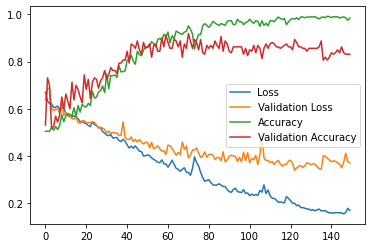

In [21]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

In [22]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

In [23]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

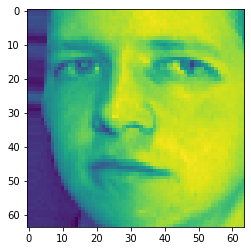

In [24]:
plt.imshow(test_image)

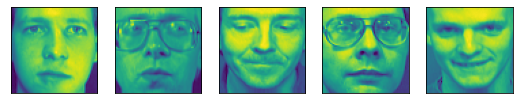

In [25]:
test_visualize(compare_images)

In [26]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [27]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [28]:
print(score)

[[0.57326925]
 [0.56959313]
 [0.00131577]
 [0.00274107]
 [0.00159505]]


In [29]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

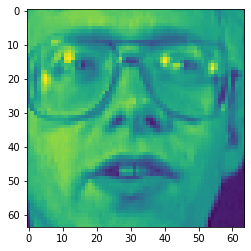

In [30]:
plt.imshow(test_image)

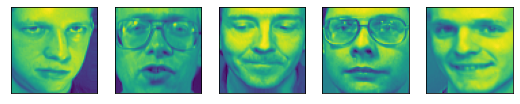

In [31]:
test_visualize(compare_images)

In [32]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [33]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [34]:
print(score)

[[0.79466313]
 [0.79489887]
 [0.0014022 ]
 [0.00210547]
 [0.00192752]]
